In [1]:
# Import statements
import os
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image = cv.imread("../maps/Lunar_LRO_LOLA_Global_LDEM_118m_Mar2014.tif",2)

(46080, 92160)
23040 46080
2000 2000
(2000, 2000)
Max: 2830, Min: -4920


True

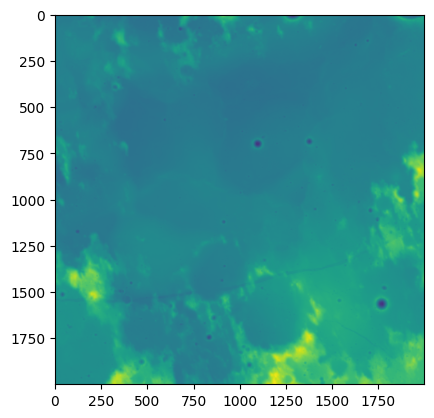

In [5]:
# Prep small section
print(image.shape)
center = np.array(image.shape,dtype=int)//2
print(center[0],center[1])
section_size = np.array([2000,2000],dtype=int)
print(section_size[0],section_size[1])
small_section = image[center[0]-section_size[0]//2:center[0]+section_size[0]//2,
											center[1]-section_size[1]//2:center[1]+section_size[1]//2]
print(small_section.shape)
print("Max: {}, Min: {}".format(np.max(small_section),np.min(small_section)))
plt.imshow(small_section)
cv.imwrite("images/interp_test.tif",small_section)

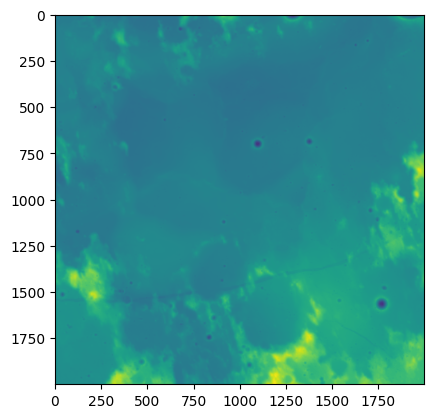

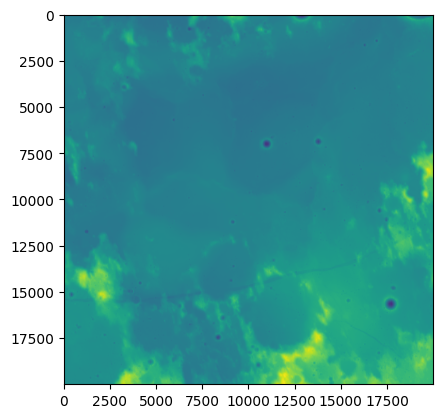

In [4]:
map = small_section
map_resize = cv.resize(map,(20000,20000),interpolation=cv.INTER_CUBIC)
plt.figure()
plt.imshow(map)
plt.figure()
plt.imshow(map_resize)

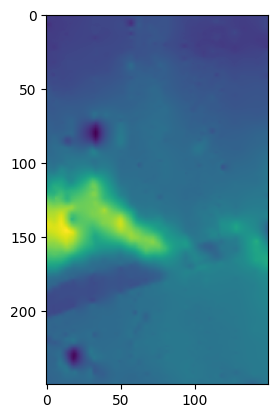

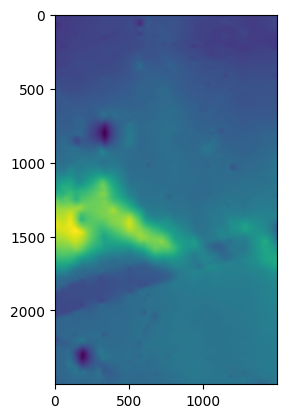

In [5]:
plt.figure()
plt.imshow(map[1250:1500,1100:1250])
plt.figure()
plt.imshow(map_resize[12500:15000,11000:12500])

In [328]:
# The Max (tm) (c) (r) derivative
def dMax(img):
  img_edge = cv.copyMakeBorder(img,0,0,1,0,cv.BORDER_REPLICATE)
  x1 = (img_edge[:,1:] - img_edge[:,:-1])
  return x1

def DOZE(map,thresh=0):
  dmap = dMax(map)
  meds = np.median(dmap,axis=0)
  offsets = np.cumsum(np.where(np.abs(meds)>=thresh,meds,0))
  #print(offsets)
  return map - offsets

def calcDOZE(map,mult=2,ks=5):
  dmap = dMax(map)
  meds = np.median(dmap,axis=0)
  abs_dmap = np.abs(dmap-local_averages(dmap,ks))
  mean = np.mean(abs_dmap)
  std = np.std(abs_dmap)
  thresh = mean + std*mult
  #meds = np.where(np.average(abs_dmap,axis=0)>thresh,meds,0)
  return meds

def local_averages(map,kernel=5):
  edge_size = (kernel-1)//2
  border_map = cv.copyMakeBorder(map,edge_size,edge_size,edge_size,edge_size,cv.BORDER_REPLICATE)
  totals = np.zeros(map.shape)
  map_j, map_i = map.shape
  for i in range(kernel):
    for j in range(kernel):
      totals += border_map[j:j+map_j,i:i+map_i]
  totals = totals/(kernel**2)
  return totals


1588 34.9054


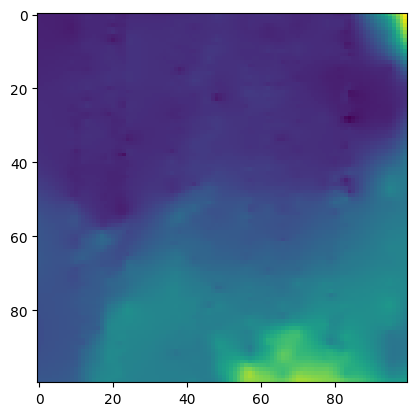

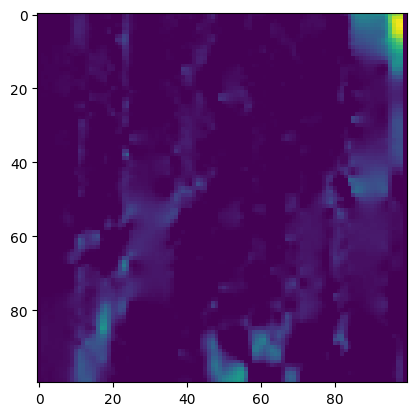

In [376]:
# The DOZER
dozer_map = map[0:100,0:100]
plt.figure()
plt.imshow(dozer_map)
dx = cv.Scharr(dozer_map,-1,1,0)
print(np.max(dx),np.average(dx))
dx = np.where(dx>5,dx,0)
plt.figure()
plt.imshow(dx)

50 -39 1.1274 0.0


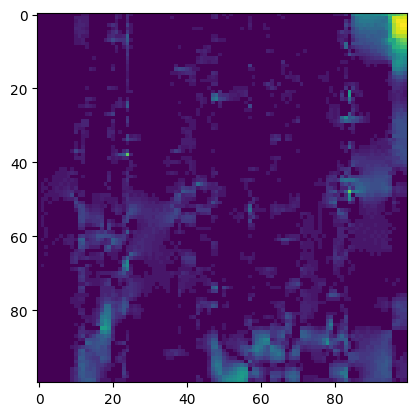

In [377]:
plt.figure()
dmap = dMax(dozer_map)
print(np.max(dmap),np.min(dmap),np.average(dmap),np.median(dmap))
mod_dmap = np.where(np.abs(dmap)>2,np.abs(dmap),0)
plt.imshow(mod_dmap)

58 -33 0.0785 0.0


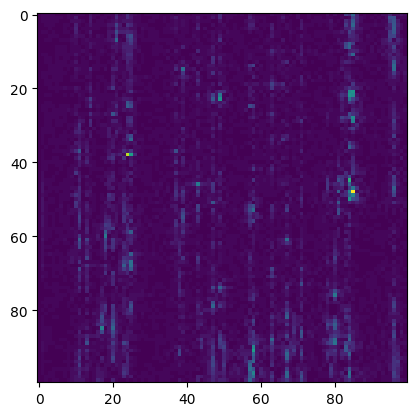

In [382]:
ddmap = dMax(dmap)
print(np.max(ddmap),np.min(ddmap),np.average(ddmap),np.median(ddmap))
mod_ddmap = np.where(np.abs(ddmap)>=1,np.abs(ddmap),0)
plt.figure()
plt.imshow(mod_ddmap)


[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.   2.   1.
  0.   0.   0.   0.   0.   0.  -1.5 -2.5 -1.5  0.5  3.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5
 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -2.5 -2.5 -2.5 -2.5 -2.5 -3.5
 -4.5 -4.5 -4.5 -4.5 -4.5 -4.5 -4.5 -4.5 -4.5 -4.5 -4.5 -3.5 -1.5 -0.5
 -0.5 -0.5]


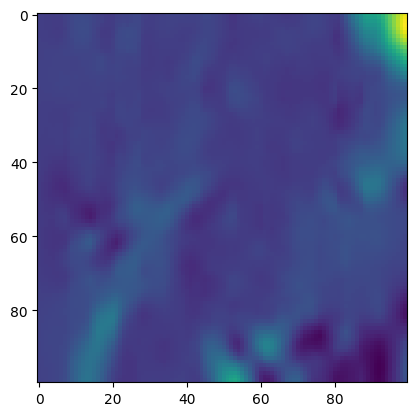

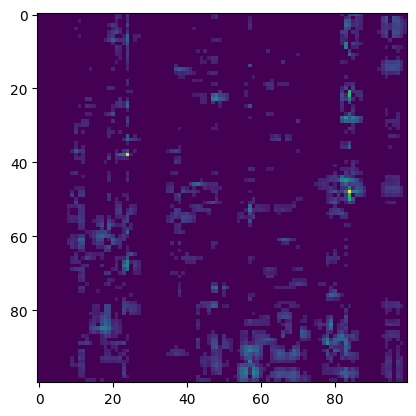

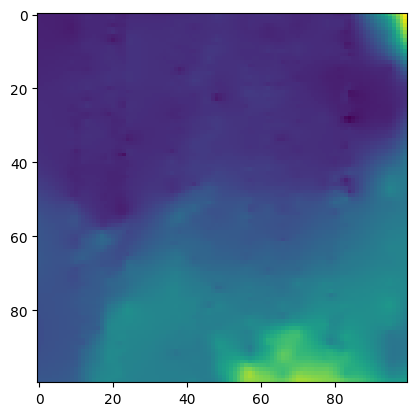

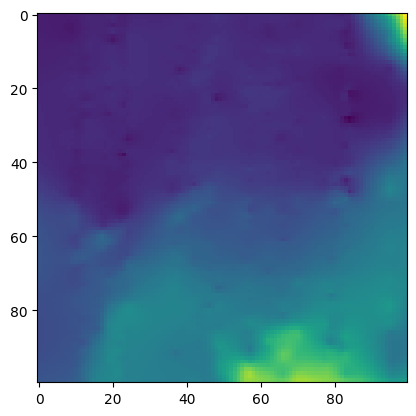

In [384]:
abs_dmap = np.abs(dmap)
local_avgs = local_averages(dmap,kernel=7)
#print(local_avgs)
avgd_dmap = np.abs(dmap-local_avgs)
mean = np.mean(avgd_dmap)
std = np.std(avgd_dmap)
mult = 0.5
thresh = mean + std*mult
dmap_bin = np.where(avgd_dmap > thresh, avgd_dmap, 0)
plt.figure()
plt.imshow(local_avgs)
plt.figure()
plt.imshow(dmap_bin)
dozed = np.cumsum(calcDOZE(dmap,mult=1,ks=5))
print(dozed)
plt.figure()
plt.imshow(dozer_map)
plt.figure()
plt.imshow(dozer_map-dozed)

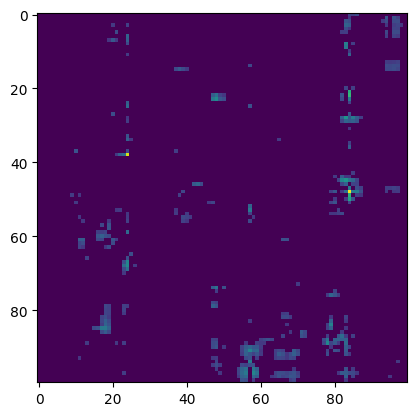

In [385]:
abs_dmap = np.abs(avgd_dmap)
mean = np.mean(abs_dmap)
std = np.std(abs_dmap)
mult = 1
thresh = mean + std*mult
dmap_bin = np.where(abs_dmap > thresh, abs_dmap, 0)
plt.imshow(dmap_bin)

In [387]:
print(np.average(abs_dmap,axis=0))
print(thresh)

[0.46938776 0.62816327 0.57183673 0.37040816 0.35612245 0.32183673
 0.42326531 0.65061224 1.22081633 1.67795918 1.90938776 2.66244898
 2.90530612 1.73510204 1.58061224 1.6277551  1.57489796 2.09
 2.48142857 3.11061224 2.40857143 2.79081633 2.37755102 2.69653061
 4.68183673 1.7044898  1.64632653 1.16142857 0.58       0.39816327
 0.35979592 0.39510204 0.35836735 0.39816327 0.64122449 0.99632653
 1.42367347 1.76510204 2.11857143 1.56591837 1.41081633 1.44326531
 1.42265306 1.69795918 1.65244898 1.57306122 1.64693878 2.90918367
 3.11571429 1.66387755 1.51918367 1.24346939 0.80122449 0.65530612
 1.18489796 1.87163265 2.35714286 3.05857143 2.52836735 2.11204082
 1.53612245 1.39959184 1.74387755 1.84428571 1.85061224 1.97428571
 2.09959184 1.97734694 2.0255102  1.91510204 1.91816327 1.67183673
 1.49734694 0.9022449  0.57510204 0.71530612 1.09959184 1.27510204
 2.36489796 2.60265306 2.43755102 2.30428571 3.30612245 4.93795918
 4.72714286 3.18673469 2.41408163 1.57857143 0.68326531 0.48163265
 

In [284]:
meds = np.median(dmap,axis=0)
avgs = np.where(np.abs(meds)>=0,meds,0)
print(meds)
print(meds.shape)
#print(np.cumsum(meds))
print(np.cumsum(avgs))

[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  2.   3.   2.
  1.   1.   0.   0.   0.   1.   0.  -1.  -1.   2.   4.5  2.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.   0.  -1.  -1.
 -1.  -1.   0.   0.   0.   0.   0.  -1.  -1.  -1.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.  -1.  -1.  -1.   0.   1.   1.
  1.   1.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.5  2.   2.5
  3.   3. ]
(100,)
[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  2.5  5.5  7.5
  8.5  9.5  9.5  9.5  9.5 10.5 10.5  9.5  8.5 10.5 15.  17.  17.  17.
 17.  17.  17.  17.  17.  17.  17.  17.  18.  18.  18.  18.  18.  18.
 18.  18.  18.  18.  18.  18.  18.  18.  18.  18.  17.  17.  16.  15.
 14.  13.  13.  13.  13.  13.  13.  12.  11.  10.  10.  10.  10.  10.
 10.  10.  10.  10.  10.  10.  10.  10.   9.   8.   7.   7.   8.   9.
 10.  11.  13.  15.  17.  19.  21.  23.  25.  27.  29.  31.5 33.5 36.

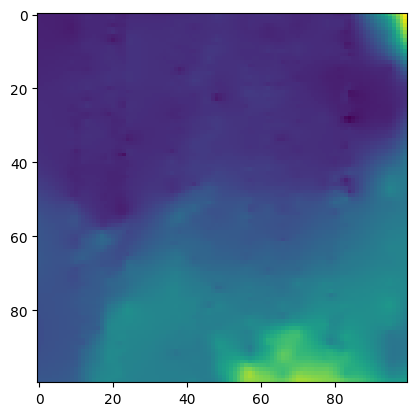

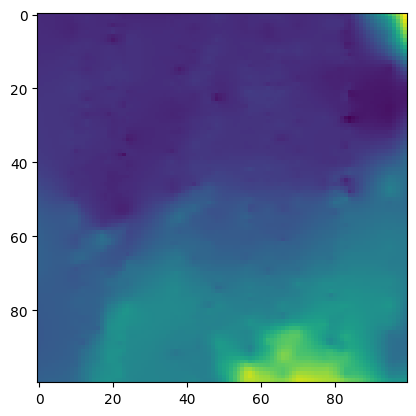

In [285]:
dozed_map = dozer_map - np.cumsum(avgs)
plt.figure()
plt.imshow(dozer_map)
plt.figure()
plt.imshow(dozed_map)

1261 15.712
1492.0 21.9454


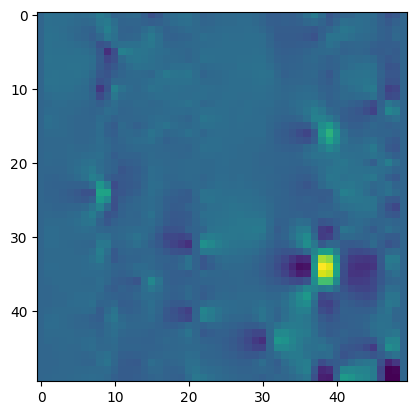

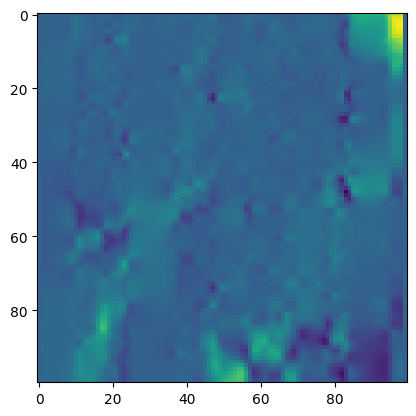

In [306]:
dxorig = cv.Scharr(dozer_map,-1,1,0)
print(np.max(dxorig),np.average(dxorig))
#dxorig = np.where(dxorig>5,dxorig,0)
plt.figure()
plt.imshow(dxorig)
dxdozed = cv.Scharr(dozed_map,-1,1,0)
print(np.max(dxdozed),np.average(dxdozed))
#dxdozed = np.where(dxdozed>5,dxdozed,0)
plt.figure()
plt.imshow(dxdozed)

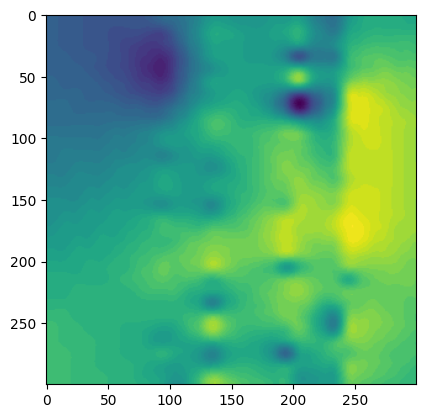

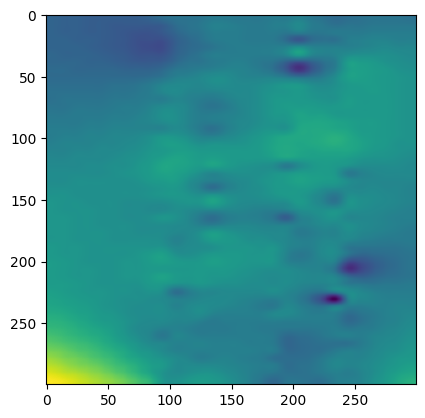

In [155]:
plt.figure()
plt.imshow(map_resize[:300,:300])
plt.figure()
plt.imshow(cv.resize(dozed_map,(300,300),interpolation=cv.INTER_CUBIC))

[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  2.0000e+00
  5.0000e+00  7.0000e+00  7.0000e+00  7.0000e+00  7.0000e+00  7.0000e+00
  7.0000e+00  7.0000e+00  7.0000e+00  7.0000e+00  7.0000e+00  9.0000e+00
  1.3500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01
  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01
  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01
  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01
  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01
  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01
  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01
  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01
  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01
  1.5500e+01  1.5500e+01  1.5500e+01  1.5500e+01  1

/tmp/ipykernel_220151/2101636129.py:20: RuntimeWarning: invalid value encountered in divide
  big_doze = big_doze[:,:,0]/big_doze[:,:,1]


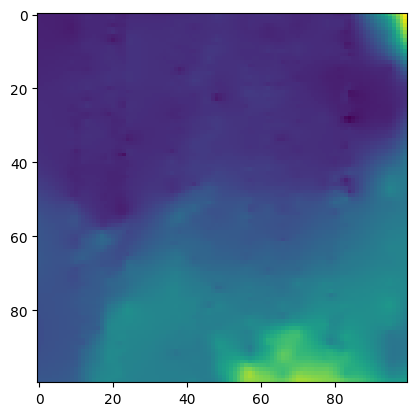

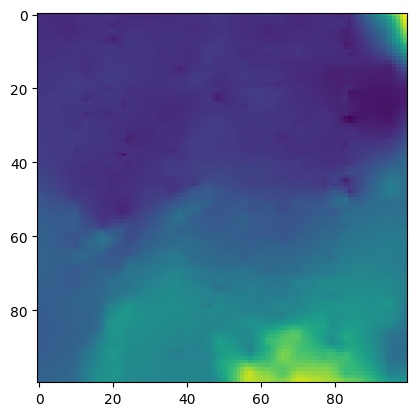

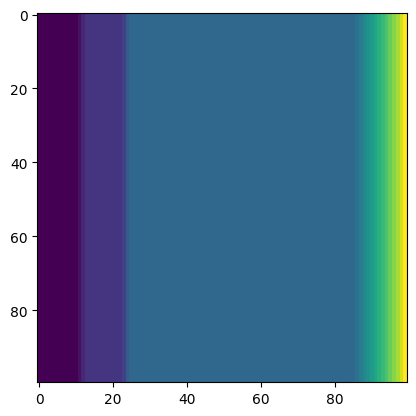

In [375]:
big_map = map[:800,:800]
big_doze = np.zeros((big_map.shape[0],big_map.shape[1],2))
big_doze[:,0,1] = 1

ks = 100
ss = 100
mult = 0.0
kernel = np.ones((ks,ks))
kernel[:,0] = 0
for i in range(((big_map.shape[0]-ks)//ss)+1):
	for j in range(((big_map.shape[1]-ks)//ss)+1):
		#values = np.tile(calcDOZE(big_map[i*ss:i*ss+ks,j*ss:j*ss+ks],thresh),(30,1))
		#print(values.shape)
		values = np.tile(calcDOZE(big_map[i*ss:i*ss+ks,j*ss:j*ss+ks],mult=mult,ks=11),(ks,1))
		#print(values.shape)
		big_doze[i*ss:i*ss+ks,j*ss:j*ss+ks,0] = values
		big_doze[i*ss:i*ss+ks,j*ss:j*ss+ks,1] += kernel

thresh = 1
big_doze = big_doze[:,:,0]/big_doze[:,:,1]
big_doze = np.cumsum(np.where(np.abs(big_doze)>thresh,big_doze,0),axis=1)
print(big_doze[0])

print(np.min(big_doze),np.max(big_doze),np.average(big_doze))
print(np.min(big_map),np.max(big_map),np.average(big_map))

x = [0,100]
y = [0,100]
plt.figure()
plt.imshow(big_map[y[0]:y[1],x[0]:x[1]])
plt.figure()
plt.imshow((big_map-big_doze)[y[0]:y[1],x[0]:x[1]])
plt.figure()
plt.imshow(big_doze[y[0]:y[1],x[0]:x[1]])